In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms


In [2]:
# Citire date
cale_fisier = r"C:\Users\Administrator\Desktop\Master\Modul 4\Metode de inspiratie biologica in inteligenta artificiala-S1\Proiect MIBIA\COD\lte_data.csv"
df = pd.read_csv(cale_fisier)
df.columns = ["type", "mcc", "net", "area", "cell", "unit", "lon", "lat", "range", "samples", "changeable", "created", "updated", "averageSignal"]
#am redenumit coloanele
#extrag doar latitudine,longitudine,si raza
stations = df[["lat", "lon", "range"]].to_numpy()
#N reprezinta nr total de celule
N = len(stations)
print(N)

16474


In [10]:
# Creez o grilă de puncte pentru testarea acoperirii
#grila este de dimensiune 30x30 adica 900
lat_vals = np.linspace(stations[:,0].min(), stations[:,0].max(), 30)
lon_vals = np.linspace(stations[:,1].min(), stations[:,1].max(), 30)
grid_points = np.array([[lat, lon] for lat in lat_vals for lon in lon_vals])


In [12]:
# Definire fitness: combinăm acoperirea și numărul de stații
#evaluare calitate solutie candidat
#verific statiile active
def fitness(individual):
    active_stations = stations[np.array(individual) == 1]
    if len(active_stations) == 0:
        return (1e6,)  # Penalizare maximă dacă nicio stație nu e activă
# numără câte puncte din grilă nu sunt acoperite de nicio stație activă
    total_uncovered = 0
#va acumula distanțele minime de la fiecare punct din grilă la cea mai apropiată stație activă.
    total_distance = 0.0
#iau fiecare punct al grilei si calc distanta intre punct si statiile active. Iau doar log si lat
    for point in grid_points:
        dists = np.linalg.norm(active_stations[:, :2] - point, axis=1)
        in_range = dists <= active_stations[:, 2]  # Acoperit? Verific daca statia acopera punctul respectiv

        if np.any(in_range):
            total_distance += np.min(dists[in_range]) #daca punctul e acoperit de cel putin o statie adaug cea mai mica distanta catre o statie 
        else:
            total_uncovered += 1
            total_distance += 1000  # Penalizare mare pt. neacoperit

    penalty_size = np.sum(individual) / N  # procent stații active în acest individ.cu cât activez mai multe, cu atât penalizarea e mai mare
    penalty_uncovered = total_uncovered / len(grid_points) #procent de pct neacoperite
    score = total_distance / len(grid_points) + 10 * penalty_uncovered + 2 * penalty_size 
    # Media distanțelor între punctele din grilă și stațiile active care le acoperă.
    #Penalizare puternică pentru punctele neacoperite
    #Penalizare pentru numărul de stații folosite 
    return (score,)
    #returnez scor total pe care algoritmul genetic încearcă să îl minimizeze.

C:\ProgramData\anaconda3\envs\MIBIA\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\ProgramData\anaconda3\envs\MIBIA\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	min    	avg    
0  	50    	1.29527	1.31339
1  	37    	1.29568	1.30522
2  	34    	1.28935	1.30124
3  	31    	1.28236	1.29736
4  	37    	1.27725	1.29346
5  	32    	1.27591	1.28854
6  	33    	1.27177	1.28379
7  	27    	1.27177	1.28045
8  	33    	1.26795	1.27651
9  	31    	1.26795	1.27412
10 	24    	1.26448	1.27185
11 	32    	1.26087	1.27063
12 	28    	1.25942	1.26853
13 	27    	1.25859	1.26535
14 	37    	1.25856	1.26359
15 	31    	1.25856	1.26211
16 	34    	1.25844	1.26206
17 	36    	1.25806	1.26147
18 	28    	1.25721	1.2601 
19 	27    	1.25493	1.25888
20 	31    	1.25581	1.25833
21 	31    	1.25562	1.25863
22 	32    	1.25355	1.25752
23 	26    	1.25513	1.25715
24 	29    	1.25289	1.2574 
25 	28    	1.25279	1.25689
26 	34    	1.25185	1.25595
27 	26    	1.25185	1.2552 
28 	29    	1.2516 	1.254  
29 	23    	1.25154	1.25349
30 	23    	1.25149	1.25326
31 	30    	1.25099	1.25357
32 	27    	1.24831	1.25227
33 	26    	1.24831	1.25229
34 	35    	1.24831	1.25218
35 	32    	1.24748	1.25234
3

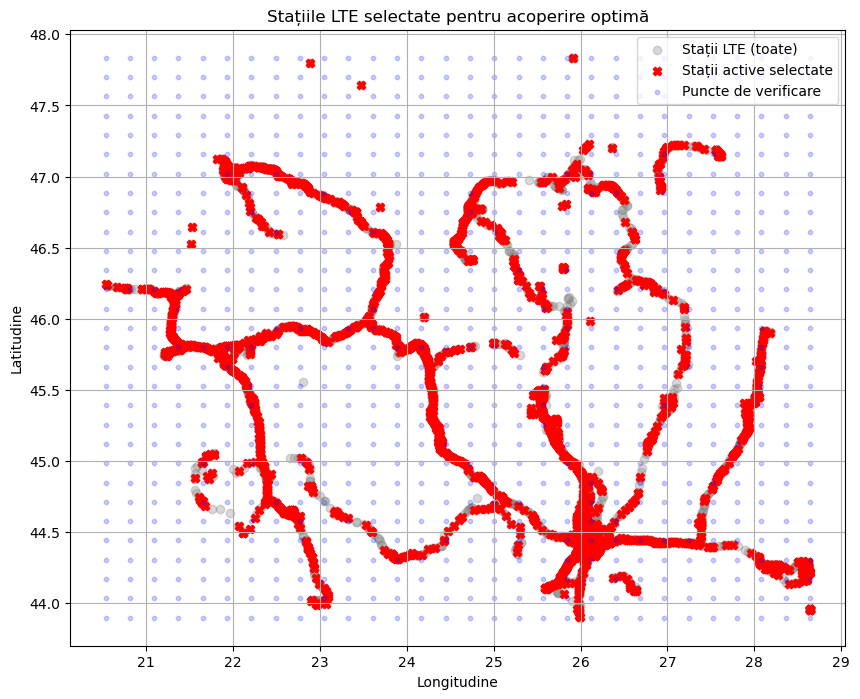

In [14]:

# DEAP setup
#Clasa FitnessMin care definește o funcție de fitness pe care vreau  s-o minimizez.
#weights=(-1.0,) -> scoruri mai mici = mai bune

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
#clasa Individual derivată din list.
#Fiecare individ este o listă de 0 și 1 (stații oprite/pornite), și are asociată o valoare de fitness.

creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
#generează un bit aleator (0 sau 1).
toolbox.register("attr_bool", random.randint, 0, 1)
#creează un individ cu N gene 
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=N)
#creează o listă de indivizi.
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
#inregistrează funcția de evaluare care calculează fitness-ul unui individ.Se apeleaza functia fitness petru a afla cat de bun este un individ
toolbox.register("evaluate", fitness)
#definesc operatorul de crossover (împerechere / recombinare) folosit pentru a genera copii noi din doi părinți.Aleg random 2 pozitii din individ iar segmentele
#dintre aceste poz sunt schimbate.crossover clasic în două puncte
toolbox.register("mate", tools.cxTwoPoint)
#fiecare genă are 5% șansă să se inverseze
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
#selecție prin turneu cu mărime 3
toolbox.register("select", tools.selTournament, tournsize=3)

def main():
    random.seed(42)
    pop = toolbox.population(n=100)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    pop, log = algorithms.eaSimple(pop, toolbox,
                                   cxpb=0.5, mutpb=0.2,
                                   ngen=50,
                                   stats=stats,#salvează min și avg fitness pentru fiecare generație.
                                   halloffame=hof,#păstrează istoria evoluției
                                   verbose=True)
#Extrag individul optim.
#Calculez câte stații sunt active.
#Afișez scorul fitness.
    best = hof[0]
    active = np.where(np.array(best) == 1)[0]
    print(f"Stații active: {len(active)} / {N}")
    print(f"Fitness: {best.fitness.values[0]}")

    # Plot rezultat
    plt.figure(figsize=(10, 8))
    plt.scatter(stations[:,1], stations[:,0], c='gray', label='Stații LTE (toate)', alpha=0.3)
    plt.scatter(stations[active,1], stations[active,0], c='red', label='Stații active selectate', marker='X')
    plt.scatter(grid_points[:,1], grid_points[:,0], c='blue', s=10, alpha=0.2, label='Puncte de verificare')
    plt.title("Stațiile LTE selectate pentru acoperire optimă")
    plt.xlabel("Longitudine")
    plt.ylabel("Latitudine")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()
